In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators import (
    PriceValidator,
    CalculationValidator,
    ReconciliationValidator,
    ConsistencyValidator,
    DataCompletenessValidator,
    FXConsistencyValidator,
    StaticDataValidator
)

# Setup plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions and {len(trades)} trades.")
print(f"Date Range: {positions['Date'].min()} to {positions['Date'].max()}")

Loaded 7721 positions and 468 trades.
Date Range: 2022-01-03 00:00:00 to 2022-12-29 00:00:00


## 1. Price Validation
We detect unrealistic price jumps using Z-Scores. A high Z-Score indicates a price movement that is statistically unlikely compared to the asset's recent volatility.

Found 3 price errors.


,date,ticker,error_type,description,severity
0,2022-12-07,CVNA,Price Spike,"Price spike detected: 3.83 (Prev: 6.71, Next: ...",High
1,2022-09-06,HSBK,Price Spike,"Price spike detected: 9.65 (Prev: 10.76, Next:...",Medium
2,2022-11-03,MBTN,Price Spike,"Price spike detected: 0.46 (Prev: 0.4, Next: 0...",Medium


Visualizing Price History for: CVNA


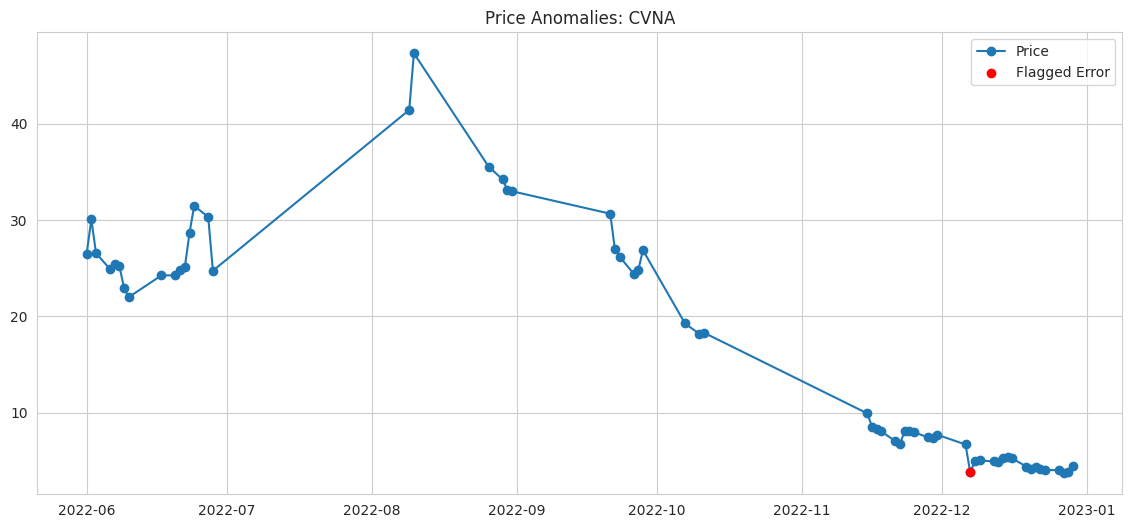

In [2]:
validator = PriceValidator(positions, trades)
price_errors = validator.validate()

print(f"Found {len(price_errors)} price errors.")
if price_errors:
    price_errors_df = pd.DataFrame([vars(e) for e in price_errors])
    display(price_errors_df.sort_values('severity').head())
    
    # Visualize Top Offender
    top_ticker = price_errors_df['ticker'].mode()[0]
    print(f"Visualizing Price History for: {top_ticker}")
    
    subset = positions[positions['P_Ticker'] == top_ticker].sort_values('Date')
    subset['Price'] = pd.to_numeric(subset['Price'], errors='coerce')
    
    plt.figure(figsize=(14, 6))
    plt.plot(subset['Date'], subset['Price'], marker='o', label='Price')
    
    # Mark errors
    err_dates = price_errors_df[price_errors_df['ticker'] == top_ticker]['date']
    plt.scatter(err_dates, subset[subset['Date'].isin(err_dates)]['Price'], color='red', label='Flagged Error', zorder=5)
    
    plt.title(f"Price Anomalies: {top_ticker}")
    plt.legend()
    plt.show()
else:
    price_errors_df = pd.DataFrame()

## 2. Reconciliation Validation
We verify that the change in position quantity matches the trades executed.
`Qty(T) = Qty(T-1) + Buy - Sell`

Found 19 reconciliation errors.


/tmp/ipykernel_208549/2032818676.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)


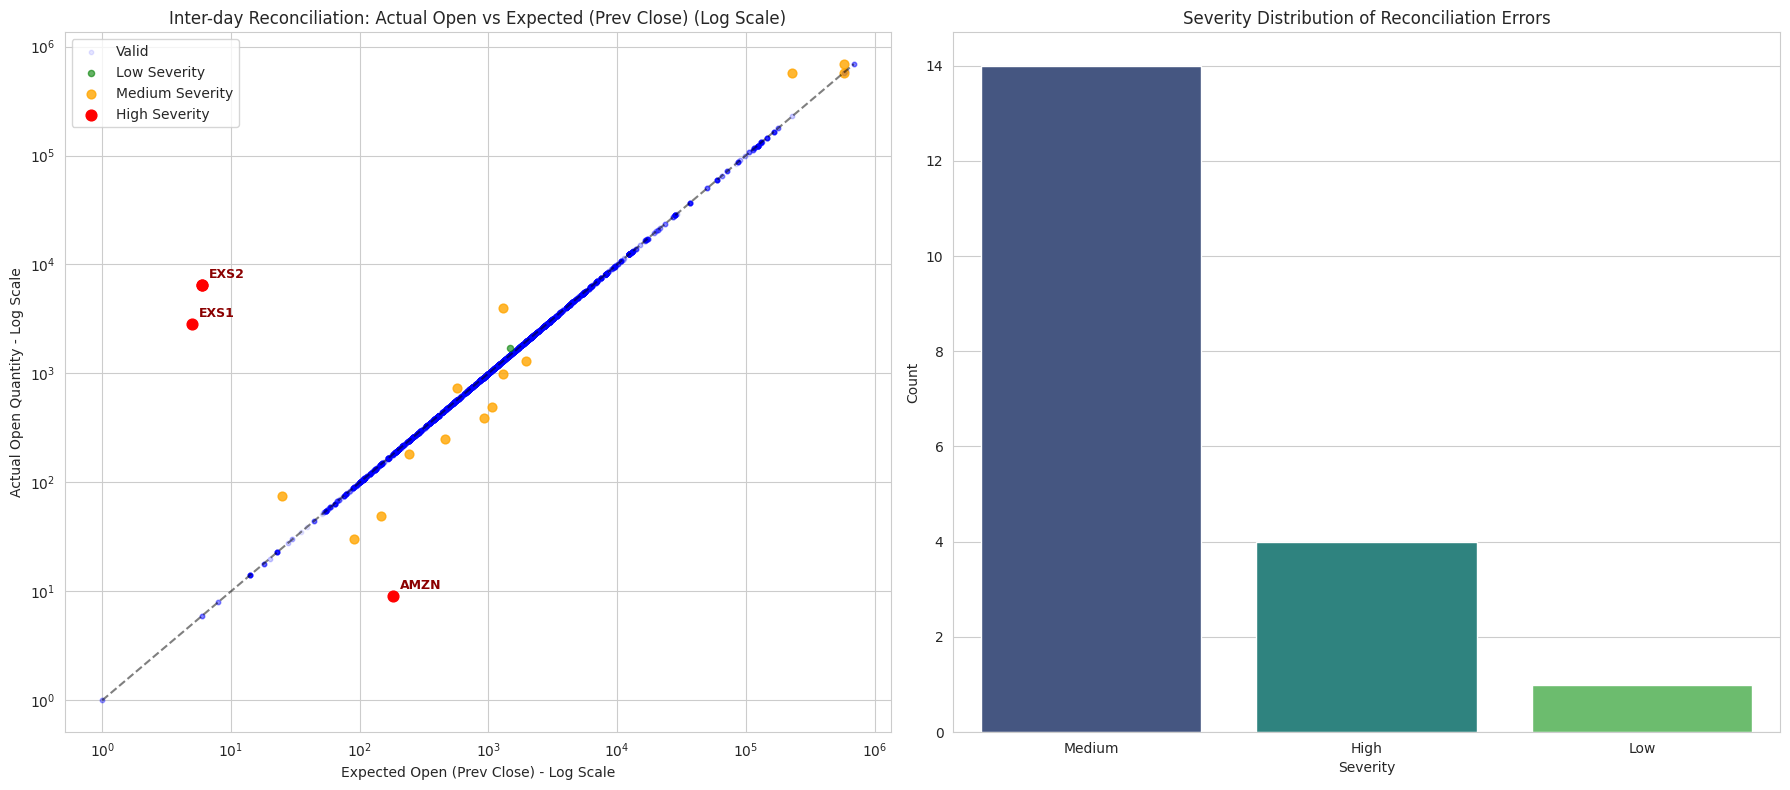

,date,ticker,error_type,description,severity
0,2022-08-23,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -983.00 != Prev Close...,Medium
1,2022-08-24,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1310.00 != Prev Clos...,Medium
2,2022-05-12,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -251.00 != Prev Close...,Medium
3,2022-05-19,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -183.00 != Prev Close...,Medium
4,2022-05-20,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -9.00 != Prev Close -...,High
5,2022-06-23,CORN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -4000.00 != Prev Clos...,Medium
6,2022-08-03,EXS1,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -2825.00 != Prev Clos...,High
7,2022-11-07,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -6450.00 != Prev Clos...,High
8,2022-11-28,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open 6450.00 != Prev Close...,High
9,2022-10-11,QQQ,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1722.00 != Prev Clos...,Low


Visualizing top 3 tickers with High Severity Inter-day errors.
Visualizing Inter-day errors for: EXS2 (Count: 2)


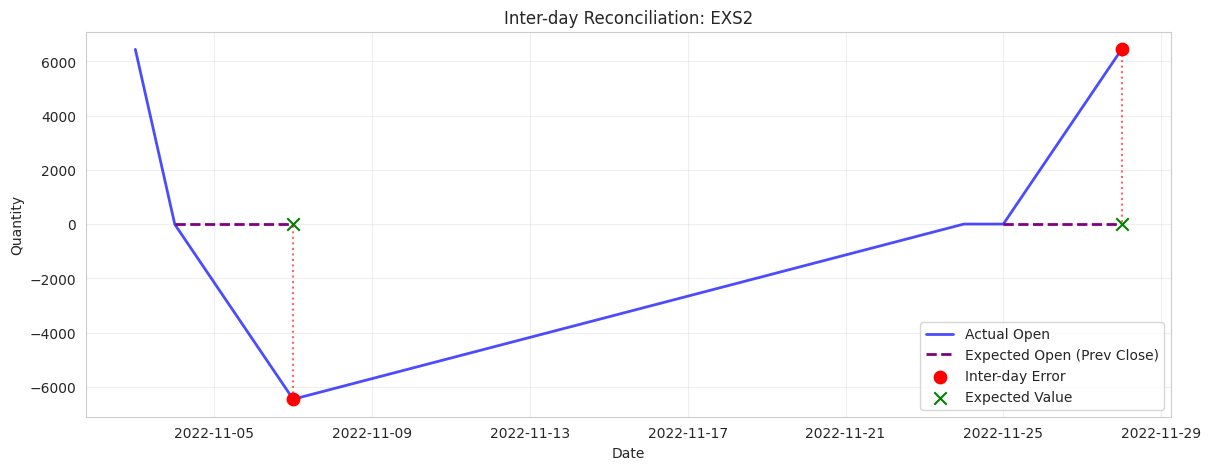

Visualizing Inter-day errors for: AMZN (Count: 1)


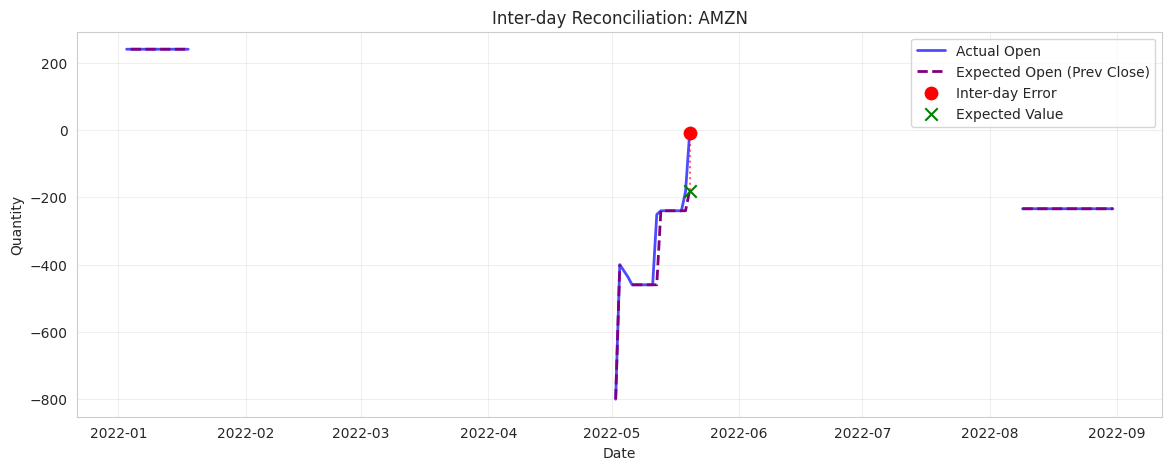

Visualizing Inter-day errors for: EXS1 (Count: 1)


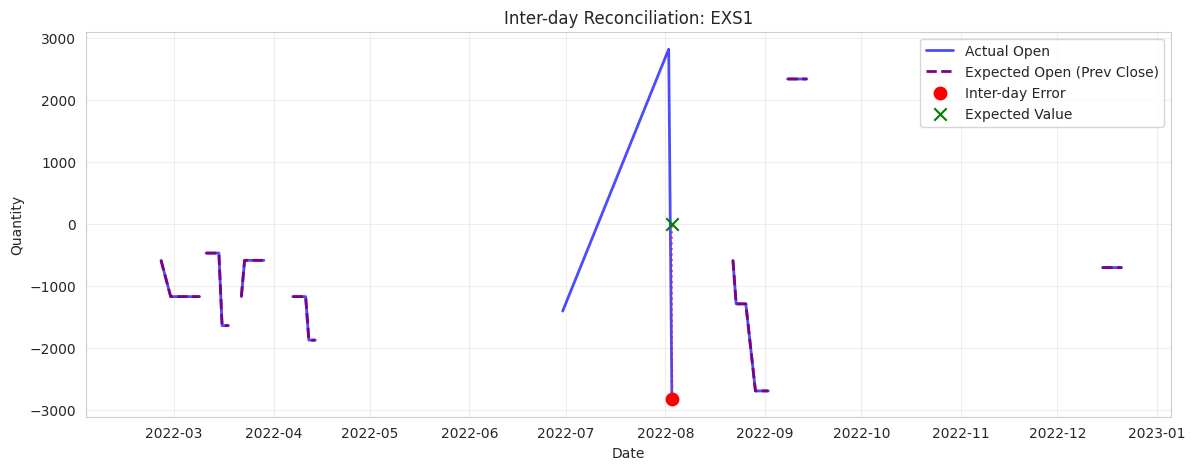

In [3]:
validator = ReconciliationValidator(positions, trades)
reconciliation_errors = validator.validate()

print(f"Found {len(reconciliation_errors)} reconciliation errors.")
if reconciliation_errors:
    reconciliation_errors_df = pd.DataFrame([vars(e) for e in reconciliation_errors])
    
    # --- Visualization 1: Inter-day Discrepancies (Log-Log Plot) & Severity ---
    
    # Filter for Inter-day errors
    inter_errors = [e for e in reconciliation_errors if "Inter-day" in e.error_type]
    
    if inter_errors:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        ax1 = axes[0]
        ax2 = axes[1]
        
        # Prepare data for plotting
        df = positions.copy()
        cols = ["Close Quantity", "Open Quantity"]
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        # Sort to get Prev Close
        df = df.sort_values(by=["P_Ticker", "Date"])
        df["Prev_Close"] = df.groupby("P_Ticker")["Close Quantity"].shift(1)
        
        # Identify error rows
        error_keys = set((e.date, e.ticker) for e in inter_errors)
        severity_map = {(e.date, e.ticker): e.severity for e in inter_errors}
        
        df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
        df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
        
        # 1. Plot "Valid" points
        valid_data = df[~df['Is_Error'] & df['Open Quantity'].notna() & df['Prev_Close'].notna()]
        ax1.scatter(valid_data["Prev_Close"].abs(), valid_data["Open Quantity"].abs(), 
                    alpha=0.1, c='blue', label='Valid', s=10)
        
        # 2. Plot Errors by Severity
        high = df[df['Severity'] == 'High']
        med = df[df['Severity'] == 'Medium']
        low = df[df['Severity'] == 'Low']
        
        if not low.empty:
            ax1.scatter(low["Prev_Close"].abs(), low["Open Quantity"].abs(), c='green', label='Low Severity', s=20, alpha=0.6)
        if not med.empty:
            ax1.scatter(med["Prev_Close"].abs(), med["Open Quantity"].abs(), c='orange', label='Medium Severity', s=40, alpha=0.8)
        if not high.empty:
            ax1.scatter(high["Prev_Close"].abs(), high["Open Quantity"].abs(), c='red', label='High Severity', s=60, alpha=1.0)
        
        # Annotate High Severity Errors
        annotated_tickers = set()
        for idx, row in high.iterrows():
            if row['P_Ticker'] not in annotated_tickers:
                ax1.annotate(f"{row['P_Ticker']}", 
                             (abs(row['Prev_Close']), abs(row['Open Quantity'])),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=9, color='darkred', fontweight='bold')
                annotated_tickers.add(row['P_Ticker'])
                if len(annotated_tickers) >= 10: break

        # Diagonal line
        max_val = max(df["Prev_Close"].abs().max(), df["Open Quantity"].abs().max())
        if pd.isna(max_val): max_val = 1
        
        min_val = min(df[df["Prev_Close"].abs() > 0]["Prev_Close"].abs().min(), 
                      df[df["Open Quantity"].abs() > 0]["Open Quantity"].abs().min())
        if pd.isna(min_val) or min_val == 0: min_val = 0.01
        
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        ax1.set_title("Inter-day Reconciliation: Actual Open vs Expected (Prev Close) (Log Scale)")
        ax1.set_xlabel("Expected Open (Prev Close) - Log Scale")
        ax1.set_ylabel("Actual Open Quantity - Log Scale")
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.legend()
        ax1.grid(True)
        
        # --- Subplot 2: Severity Distribution ---
        severity_counts = reconciliation_errors_df['severity'].value_counts()
        sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)
        ax2.set_title("Severity Distribution of Reconciliation Errors")
        ax2.set_xlabel("Severity")
        ax2.set_ylabel("Count")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No Inter-day errors to visualize.")

    display(reconciliation_errors_df.head(10))

    # --- Visualization 2: Time Series Analysis (Inter-day) ---
    
    def clean_float(x):
        try:
            return float(str(x).replace(',', '').replace(' ', ''))
        except:
            return 0.0

    def visualize_inter_day_error(ticker, error_list, positions_df):
        # Filter errors for this ticker
        ticker_errors = [e for e in error_list if e.ticker == ticker and "Inter-day" in e.error_type]
        if not ticker_errors:
            return

        print(f"Visualizing Inter-day errors for: {ticker} (Count: {len(ticker_errors)})")
        
        # Prepare data
        ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        ticker_df['Open'] = ticker_df['Open Quantity'].apply(clean_float)
        ticker_df['Close'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Prev_Close'] = ticker_df['Close'].shift(1)
        
        plt.figure(figsize=(14, 5))
        
        plt.plot(ticker_df['Date'], ticker_df['Open'], label='Actual Open', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Prev_Close'], label='Expected Open (Prev Close)', color='purple', linestyle='--', linewidth=2)
        
        # Highlight errors
        error_dates = [e.date for e in ticker_errors]
        error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
        
        if not error_points.empty:
            # Plot Actual Open
            plt.scatter(error_points['Date'], error_points['Open'], color='red', s=80, zorder=5, label='Inter-day Error')
            
            # Plot Expected Open (Prev Close)
            valid_points = error_points.dropna(subset=['Prev_Close'])
            
            if not valid_points.empty:
                plt.scatter(valid_points['Date'], valid_points['Prev_Close'], color='green', s=80, zorder=5, marker='x', label='Expected Value')
                
                # Draw vertical lines
                for _, row in valid_points.iterrows():
                    plt.plot([row['Date'], row['Date']], [row['Open'], row['Prev_Close']], 
                             color='red', linestyle=':', linewidth=1.5, alpha=0.6)

        plt.title(f"Inter-day Reconciliation: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Quantity")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Filter for High Severity Inter-day errors
    inter_high = [e for e in reconciliation_errors if e.severity == 'High' and "Inter-day" in e.error_type]

    if inter_high:
        # Count recurrence
        from collections import Counter
        ticker_counts = Counter(e.ticker for e in inter_high)
        top_tickers = [t[0] for t in ticker_counts.most_common(3)]
        
        print(f"Visualizing top {len(top_tickers)} tickers with High Severity Inter-day errors.")
        for ticker in top_tickers:
            visualize_inter_day_error(ticker, inter_high, positions)
    else:
        print("No High Severity Inter-day errors found.")

else:
    reconciliation_errors_df = pd.DataFrame()

## 3. Calculation Validation
We verify that `Value in USD` = `Quantity` * `Price` * `Exchange Rate`.
We also check for systematic errors (e.g., missing multipliers like x100).

Found 620 calculation errors.


,date,ticker,error_type,description,severity
0,2022-01-03,ANTO,Calculation Error,Value Mismatch: Reported -30773.39 vs Calc -22...,Low
1,2022-01-04,ANTO,Calculation Error,Value Mismatch: Reported -31588.64 vs Calc -23...,Low
2,2022-01-05,ANTO,Calculation Error,Value Mismatch: Reported -31873.42 vs Calc -23...,Low
3,2022-01-06,ANTO,Calculation Error,Value Mismatch: Reported -30683.04 vs Calc -22...,Low
4,2022-01-07,ANTO,Calculation Error,Value Mismatch: Reported -31565.09 vs Calc -23...,Low


Visualizing Systematic Error for: XTB


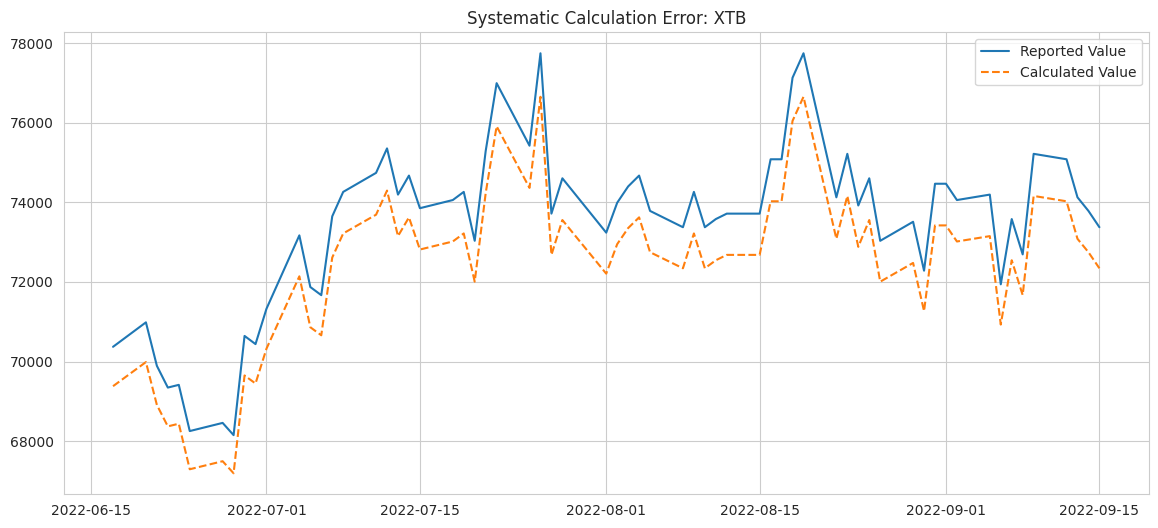

In [4]:
validator = CalculationValidator(positions, trades)
calculation_errors = validator.validate()

print(f"Found {len(calculation_errors)} calculation errors.")
if calculation_errors:
    calculation_errors_df = pd.DataFrame([vars(e) for e in calculation_errors])
    display(calculation_errors_df.head())
    
    # Visualize Systematic Errors (if any)
    sys_errors = calculation_errors_df[calculation_errors_df['description'].str.contains("Systematic")]
    if not sys_errors.empty:
        top_sys = sys_errors['ticker'].mode()[0]
        print(f"Visualizing Systematic Error for: {top_sys}")
        
        subset = positions[positions['P_Ticker'] == top_sys].sort_values('Date').copy()
        subset['Price'] = pd.to_numeric(subset['Price'], errors='coerce')
        subset['Close Quantity'] = pd.to_numeric(subset['Close Quantity'], errors='coerce')
        subset['Exchange Rate'] = pd.to_numeric(subset['Exchange Rate'], errors='coerce')
        subset['Value in USD'] = pd.to_numeric(subset['Value in USD'], errors='coerce')
        
        subset['Calc_Value'] = subset['Price'] * subset['Close Quantity'] * subset['Exchange Rate']
        
        plt.figure(figsize=(14, 6))
        plt.plot(subset['Date'], subset['Value in USD'], label='Reported Value')
        plt.plot(subset['Date'], subset['Calc_Value'], label='Calculated Value', linestyle='--')
        plt.title(f"Systematic Calculation Error: {top_sys}")
        plt.legend()
        plt.show()
else:
    calculation_errors_df = pd.DataFrame()

## 4. Consistency Validation

This section checks for consistency between the **Trade Price** (execution price) and the **Market Price** (reported closing price) for the same day. Significant deviations are flagged as potential errors.

We will specifically examine **BNTX** as a case study using a log-log plot to visualize the relationship between trade prices and market prices.

Found 27 consistency errors.


,date,ticker,error_type,description,severity
0,2022-02-07,RIVN,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 62.79 vs Market Pr...,Low
1,2022-02-28,DQ,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 44.90 vs Market Pr...,Low
2,2022-03-09,KAP,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 32.84 vs Market Pr...,High
3,2022-03-11,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 144.75 vs Market P...,Low
4,2022-03-16,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 152.09 vs Market P...,Low


Visualizing Consistency for: BNTX


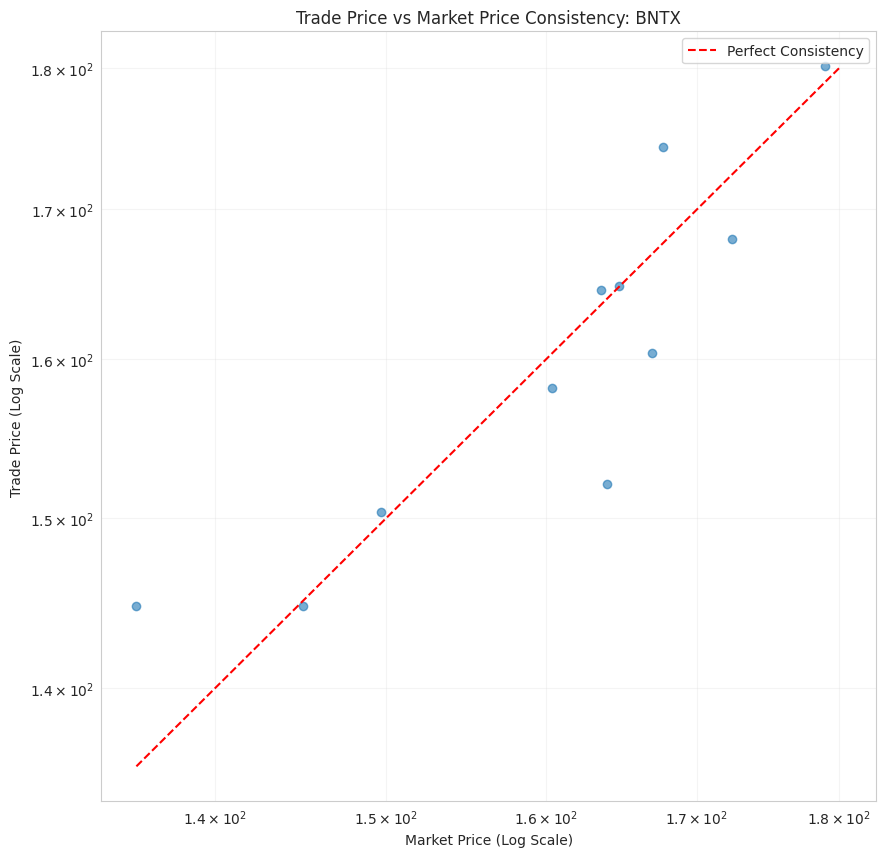

In [5]:
validator = ConsistencyValidator(positions, trades)
consistency_errors = validator.validate()

print(f"Found {len(consistency_errors)} consistency errors.")
if consistency_errors:
    consistency_errors_df = pd.DataFrame([vars(e) for e in consistency_errors])
    display(consistency_errors_df.head())
else:
    consistency_errors_df = pd.DataFrame()

# Specific BNTX Example with Log-Log Graph
ticker = 'BNTX'
print(f"Visualizing Consistency for: {ticker}")

# Filter for trades of BNTX
bntx_trades = positions[(positions['P_Ticker'] == ticker) & (positions['Traded Today'].abs() > 0)].copy()

if not bntx_trades.empty:
    # Ensure numeric
    bntx_trades['Price'] = pd.to_numeric(bntx_trades['Price'], errors='coerce')
    bntx_trades['Trade Price'] = pd.to_numeric(bntx_trades['Trade Price'], errors='coerce')
    
    plt.figure(figsize=(10, 10))
    plt.scatter(bntx_trades['Price'], bntx_trades['Trade Price'], alpha=0.6)
    
    # Add diagonal line for reference
    min_val = min(bntx_trades['Price'].min(), bntx_trades['Trade Price'].min())
    max_val = max(bntx_trades['Price'].max(), bntx_trades['Trade Price'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Consistency')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Market Price (Log Scale)')
    plt.ylabel('Trade Price (Log Scale)')
    plt.title(f'Trade Price vs Market Price Consistency: {ticker}')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()
else:
    print(f"No trades found for {ticker}")

## 5. Data Completeness Validation

We check for missing essential data points such as Prices, Dates, and Tickers.
Missing values are flagged as **Medium** severity errors, as they impede analysis but do not necessarily indicate incorrect data, just incomplete data.

Found 584 completeness errors.


,date,ticker,error_type,description,severity
0,2022-01-04,ADBE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
1,2022-01-04,ADI,Missing Data,Missing value for critical column: 'Close Quan...,Medium
2,2022-01-04,NFLX,Missing Data,Missing value for critical column: 'Close Quan...,Medium
3,2022-01-04,NUE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
4,2022-01-04,PLZL,Missing Data,Missing value for critical column: 'Close Quan...,Medium


Missing Data Distribution:


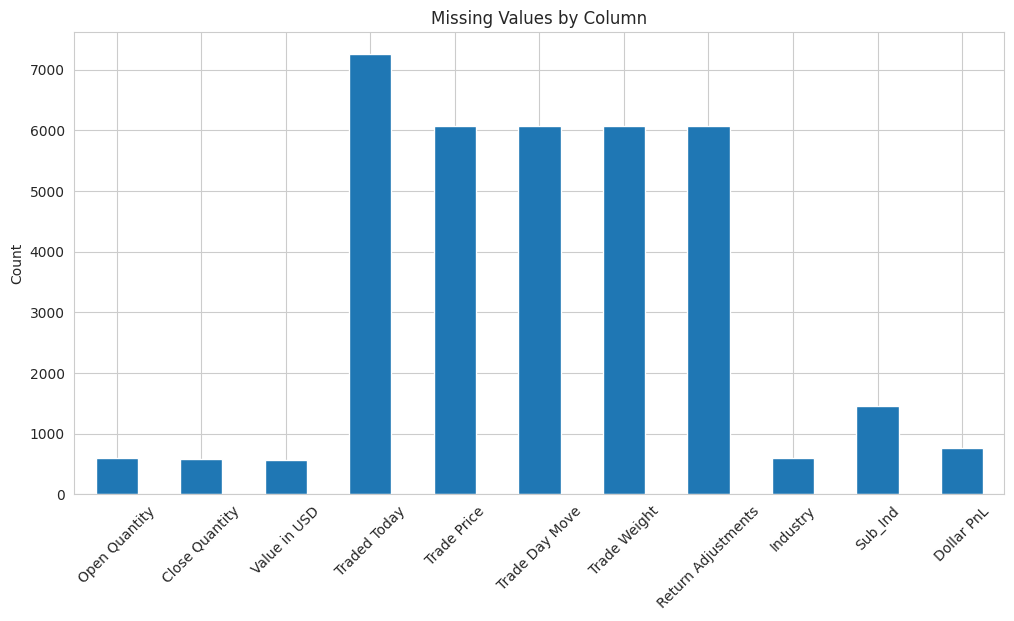

In [6]:
validator = DataCompletenessValidator(positions, trades)
completeness_errors = validator.validate()

print(f"Found {len(completeness_errors)} completeness errors.")
if completeness_errors:
    completeness_errors_df = pd.DataFrame([vars(e) for e in completeness_errors])
    display(completeness_errors_df.head())
    
    # Visualize Missing Data by Column
    print("Missing Data Distribution:")
    missing_counts = positions.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if not missing_counts.empty:
        plt.figure(figsize=(12, 6))
        missing_counts.plot(kind='bar')
        plt.title("Missing Values by Column")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
else:
    completeness_errors_df = pd.DataFrame()

## 6. FX Validation

We validate that the implied exchange rates in the data match the reported exchange rates.

In [7]:
validator = FXConsistencyValidator(positions, trades)
fx_errors = validator.validate()

print(f"Found {len(fx_errors)} FX errors.")
if fx_errors:
    fx_errors_df = pd.DataFrame([vars(e) for e in fx_errors])
    display(fx_errors_df.head())
else:
    fx_errors_df = pd.DataFrame()

Found 0 FX errors.


## 7. Static Data Validation

We check for invalid or missing static data, such as Ticker symbols and ISINs.

In [8]:
validator = StaticDataValidator(positions, trades)
static_errors = validator.validate()

print(f"Found {len(static_errors)} static data errors.")
if static_errors:
    static_errors_df = pd.DataFrame([vars(e) for e in static_errors])
    display(static_errors_df.head())
else:
    static_errors_df = pd.DataFrame()

Found 169 static data errors.


,date,ticker,error_type,description,severity
0,2022-11-09,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
1,2022-11-10,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
2,2022-11-24,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
3,2022-12-07,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
4,2022-12-08,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium


## 8. Aggregation & Conclusion
We aggregate all findings to identify the most problematic assets and the most common error types.

Total Errors Found: 1422


/tmp/ipykernel_208549/3496321328.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=master_df, y='error_type', order=master_df['error_type'].value_counts().index, palette='magma')


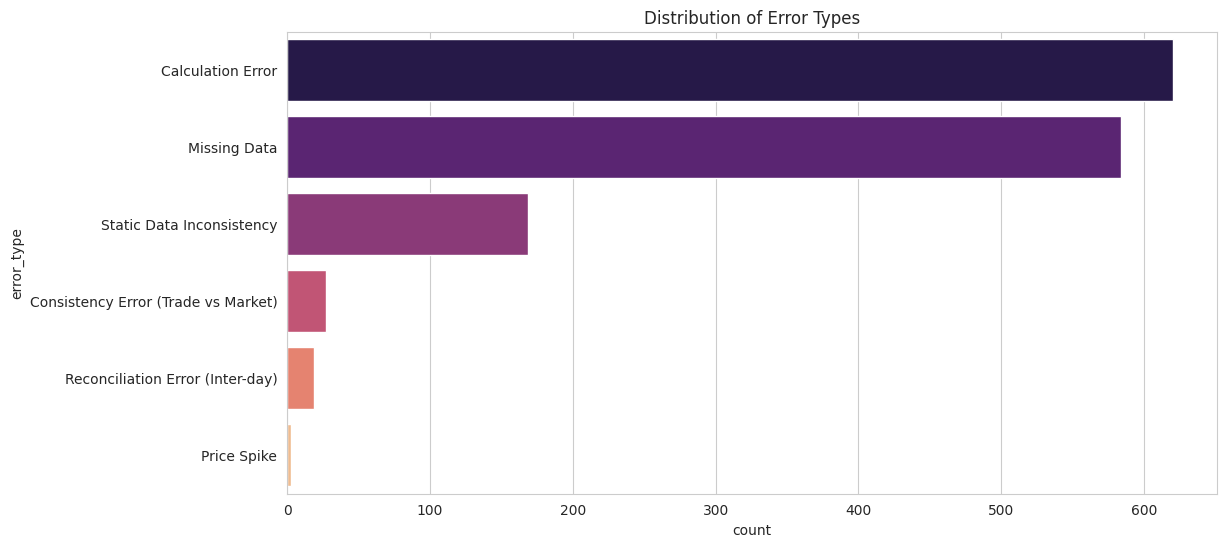

/tmp/ipykernel_208549/3496321328.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tickers.values, y=top_tickers.index, palette='coolwarm')


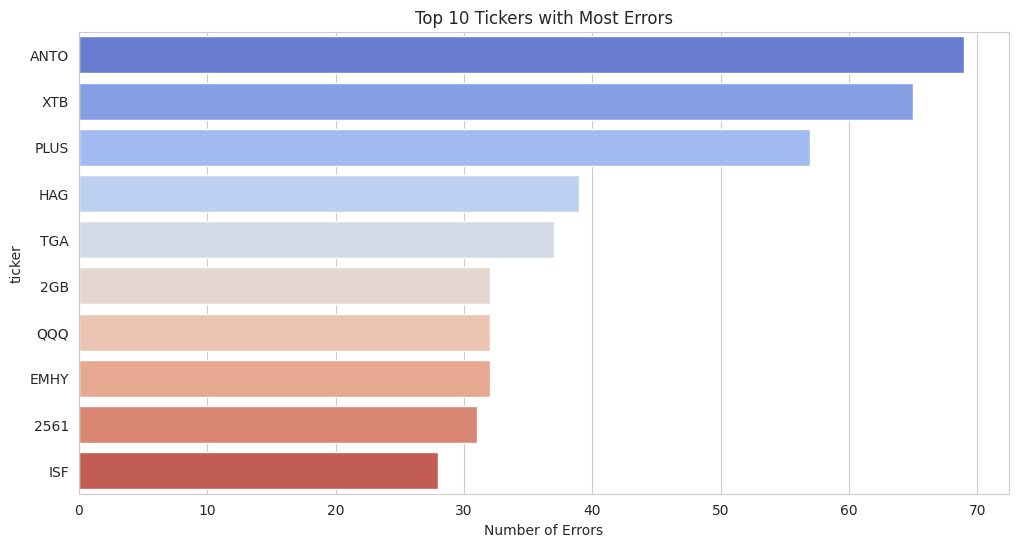

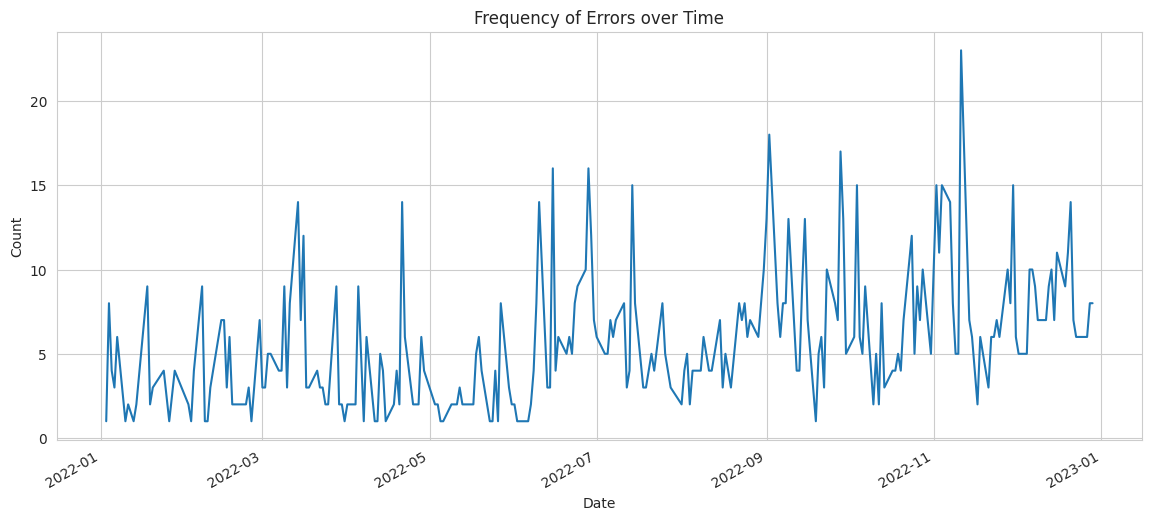

error_type,Calculation Error,Consistency Error (Trade vs Market),Missing Data,Price Spike,Reconciliation Error (Inter-day),Static Data Inconsistency,Total
ticker,,,,,,,
ANTO,60,0,6,0,0,3,69
XTB,64,0,1,0,0,0,65
PLUS,56,0,1,0,0,0,57
HAG,37,0,1,0,0,1,39
TGA,30,0,1,0,0,6,37
2GB,31,0,1,0,0,0,32
QQQ,3,0,27,0,2,0,32
EMHY,0,0,1,0,0,31,32
2561,30,0,1,0,0,0,31


In [9]:
# Aggregate all errors
all_errors_dfs = [
    completeness_errors_df,
    static_errors_df,
    price_errors_df,
    fx_errors_df,
    consistency_errors_df,
    reconciliation_errors_df,
    calculation_errors_df
]

# Filter out empty DataFrames
all_errors_dfs = [df for df in all_errors_dfs if not df.empty]

if all_errors_dfs:
    master_df = pd.concat(all_errors_dfs, ignore_index=True)
    print(f"Total Errors Found: {len(master_df)}")
    
    # 1. Errors by Type
    plt.figure(figsize=(12, 6))
    sns.countplot(data=master_df, y='error_type', order=master_df['error_type'].value_counts().index, palette='magma')
    plt.title("Distribution of Error Types")
    plt.show()
    
    # 2. Top Offenders (Tickers)
    top_tickers = master_df['ticker'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_tickers.values, y=top_tickers.index, palette='coolwarm')
    plt.title("Top 10 Tickers with Most Errors")
    plt.xlabel("Number of Errors")
    plt.show()
    
    # 3. Errors over Time
    master_df['Date'] = pd.to_datetime(master_df['date'])
    errors_by_date = master_df.groupby('Date').size()
    
    plt.figure(figsize=(14, 6))
    errors_by_date.plot()
    plt.title("Frequency of Errors over Time")
    plt.ylabel("Count")
    plt.show()
    
    # Display Summary Table
    summary = master_df.groupby(['ticker', 'error_type']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)
    display(summary.sort_values('Total', ascending=False).head(10))
else:
    print("No errors found across all validators.")

## Conclusion & Next Steps

### Summary of Findings
The automated analysis has revealed several critical data quality issues:
1.  **Calculation Errors**: Significant discrepancies between reported Market Value and calculated value (Qty * Price). Many appear to be systematic (missing multipliers).
2.  **Reconciliation Breaks**: Positions changing without corresponding trades, or trades not reflecting in positions.
3.  **Price Anomalies**: Unrealistic price spikes detected in several assets.
4.  **Data Gaps**: Missing prices or FX rates preventing valuation.

### Next Steps
1.  **Fix Systematic Errors**: Apply the detected multipliers (e.g., x100) to correct the bulk of calculation errors.
2.  **Investigate Reconciliation Breaks**: Manual review of trade logs for the top offending tickers.
3.  **Data Source Review**: The high number of missing prices suggests a feed issue that needs addressing.
4.  **Weight Validation**: Re-implement a robust weight validator once the underlying value data is cleaned.
